# Sentiment Analysis on Movie Review DataSet of Kaggle

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Reading data

df_train = pd.read_csv('train.tsv', sep='\t')
df_test = pd.read_csv('train.tsv', sep='\t')

In [3]:
df_train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [4]:
df_test.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [5]:
#  Count the categories
df_train.Sentiment.value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
PhraseId      156060 non-null int64
SentenceId    156060 non-null int64
Phrase        156060 non-null object
Sentiment     156060 non-null int64
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


### Removing undesired columns


In [7]:
df_train.drop(["PhraseId","SentenceId"], axis=1, inplace=True)

In [8]:
df_train.head()

,Phrase,Sentiment
0,A series of escapades demonstrating the adage ...,1
1,A series of escapades demonstrating the adage ...,2
2,A series,2
3,A,2
4,series,2


In [9]:
df_train['phrase_len'] = [len(phrase) for phrase in df_train.Phrase]
df_train.head(5)

,Phrase,Sentiment,phrase_len
0,A series of escapades demonstrating the adage ...,1,188
1,A series of escapades demonstrating the adage ...,2,77
2,A series,2,8
3,A,2,1
4,series,2,6


### Distribution of length of reviews

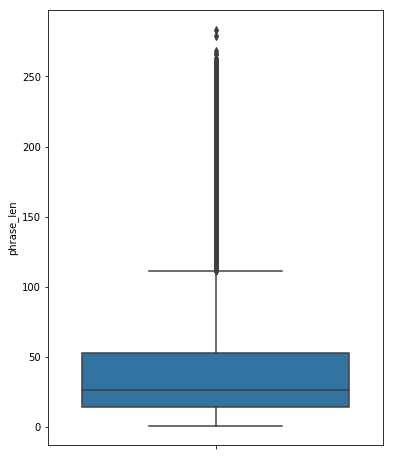

In [10]:
plt.figure(figsize=(6,8))
sns.boxplot(y=df_train.phrase_len)

In [11]:
df_train[df_train.phrase_len > 150].head()

,Phrase,Sentiment,phrase_len
0,A series of escapades demonstrating the adage ...,1,188
116,A positively thrilling combination of ethnogra...,3,152
306,Kung Pow is Oedekerk 's realization of his chi...,1,162
310,is Oedekerk 's realization of his childhood dr...,2,153
311,is Oedekerk 's realization of his childhood dr...,0,151


In [12]:
# Lets see what is inside review
df_train[df_train.phrase_len > 150].loc[116].Phrase

'A positively thrilling combination of ethnography and all the intrigue , betrayal , deceit and murder of a Shakespearean tragedy or a juicy soap opera .'

### Filter out positive and negative reviews

In [13]:
neg_phrases = df_train[df_train.Sentiment == 0]
neg_words = []
for word in neg_phrases.Phrase:
    neg_words.append(word)

neg_words[:4]

['would have a hard time sitting through this one',
 'have a hard time sitting through this one',
 'Aggressive self-glorification and a manipulative whitewash',
 'self-glorification and a manipulative whitewash']

Now combine the list using Pandas.Series.str.cat

In [14]:
neg_text = pd.Series(neg_words).str.cat(sep=' ')
neg_text[:200]

'would have a hard time sitting through this one have a hard time sitting through this one Aggressive self-glorification and a manipulative whitewash self-glorification and a manipulative whitewash Tro'

In [15]:
pos_phrases = df_train[df_train.Sentiment == 4]
pos_words = []
for words in pos_phrases.Phrase:
    pos_words.append(words)
pos_text = pd.Series(pos_words).str.cat(sep=' ')
pos_text[:200]

'This quiet , introspective and entertaining independent is worth seeking . quiet , introspective and entertaining independent entertaining is worth seeking A positively thrilling combination of ethnog'

### WorldCloud for negatively classified reviews

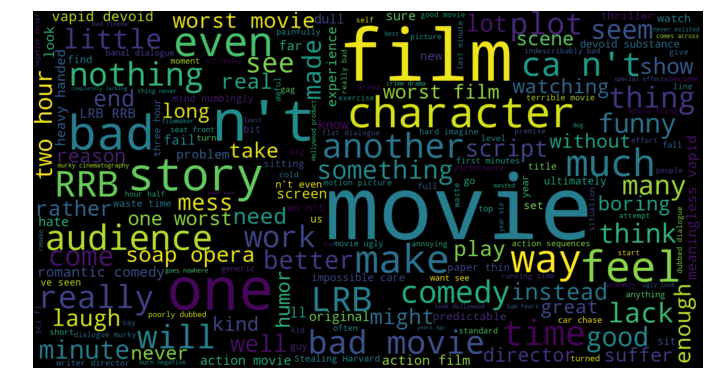

In [16]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=1500, height=800, max_font_size=200).generate(neg_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Some of the big words can be interpreted quite neutral, such as "movie","film" etc.

### World Cloud for postively classified movie

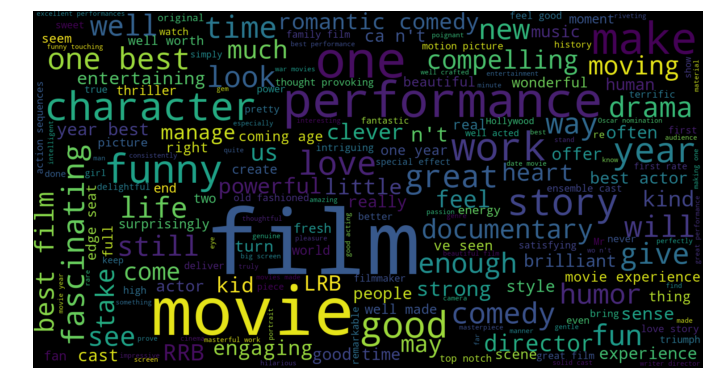

In [17]:
wordcloud = WordCloud(width=1500,height=800, max_font_size=200).generate(pos_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Here alsone some neutral words like "movie", "film"
but got positive words like "good", "best", "fascinating" , "well" etc

### Term Frequencies of each Sentiment class

We are going to use Zipf's law.

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
cvector = CountVectorizer(min_df = 0.0, max_df=1.0, ngram_range=(1,2))
cvector.fit(df_train.Phrase)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0.0,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [19]:
len(cvector.get_feature_names())

94644

### Finding Term Frequency for 'negative' sentiments

In [20]:
neg_matrix = cvector.transform(df_train[df_train.Sentiment == 0].Phrase)
somewhat_neg_matrix = cvector.transform(df_train[df_train.Sentiment == 1].Phrase)
neu_matrix = cvector.transform(df_train[df_train.Sentiment == 2].Phrase)
somewhat_pos_matrix = cvector.transform(df_train[df_train.Sentiment == 3].Phrase)
pos_matrix = cvector.transform(df_train[df_train.Sentiment == 4].Phrase)

In [21]:
neg_words = neg_matrix.sum(axis = 0)
neg_words_freq = [(word, neg_words[0,idx]) for word,idx in cvector.vocabulary_.items()]
#print(neg_words_freq[:10])
neg_tf = pd.DataFrame(list(sorted(neg_words_freq, key= lambda x: x[1], reverse=True)),columns = ['Terms', 'negative'])
neg_tf.head()

,Terms,negative
0,the,3462
1,and,2549
2,of,2277
3,to,1916
4,is,1372


### Term Frequency for somewhat negative

In [22]:
somewhat_neg_words = somewhat_neg_matrix.sum(axis=0)
somewhat_neg_words_freq = [(word, somewhat_neg_words[0, idx]) for word, idx in cvector.vocabulary_.items()]
somewhat_neg_tf = pd.DataFrame(list(sorted(somewhat_neg_words_freq, key = lambda x: x[1], reverse=True)), columns = ['Terms', 'some-negative'])
somewhat_neg_tf.head(10)

,Terms,some-negative
0,the,10885
1,of,6660
2,and,6204
3,to,5571
4,is,3362
5,it,3067
6,that,2982
7,in,2965
8,as,2184
9,for,1739


### Term Frequency for neutral

In [23]:
neu_words = neu_matrix.sum(axis=0)
neu_words_freq = [(word, neu_words[0, idx]) for word, idx in cvector.vocabulary_.items()]
neu_words_tf = pd.DataFrame(list(sorted(neu_words_freq, key = lambda x: x[1], reverse=True)),columns=['Terms', 'neutral'])
neu_words_tf.head(10)

,Terms,neutral
0,the,20619
1,of,12287
2,and,10241
3,to,8295
4,in,5562
5,it,3791
6,is,3703
7,that,3677
8,as,2941
9,for,2939


### Term Frequency for some positive sentiments

In [25]:
somewhat_pos_words = somewhat_pos_matrix.sum(axis=0)
somewhat_pos_words_freq = [(word, somewhat_pos_words[0, idx]) for word, idx in cvector.vocabulary_.items()]

somewhat_pos_words_tf = pd.DataFrame(list(sorted(somewhat_pos_words_freq, key = lambda x: x[1], reverse = True)), columns=['Terms', 'some_postive'])

In [26]:
somewhat_pos_words_tf.head(10)

,Terms,some_postive
0,the,12459
1,and,9180
2,of,8405
3,to,5411
4,is,3489
5,in,3365
6,that,3280
7,it,2927
8,with,2365
9,an,2061


### Term Frequency for Postive Sentiments

In [27]:
pos_words = pos_matrix.sum(axis=0)
pos_words_freq = [(word, pos_words[0, idx]) for word, idx in cvector.vocabulary_.items()]

pos_words_tf = pd.DataFrame(list(sorted(pos_words_freq, key = lambda x: x[1], reverse=True)), columns=['Terms','positive'])
pos_words_tf.head(10)

,Terms,positive
0,the,4208
1,and,4003
2,of,3073
3,to,1568
4,is,1550
5,that,1260
6,in,1067
7,film,949
8,with,929
9,it,863


In [28]:
# Now lets combine all tf's
term_freq_df = pd.concat([neg_tf, somewhat_neg_tf, neu_words_tf, somewhat_pos_words_tf, pos_words_tf], axis=1 )

In [29]:
term_freq_df.head(10)

,Terms,negative,Terms,some-negative,Terms,neutral,Terms,some_postive,Terms,positive
0,the,3462,the,10885,the,20619,the,12459,the,4208
1,and,2549,of,6660,of,12287,and,9180,and,4003
2,of,2277,and,6204,and,10241,of,8405,of,3073
3,to,1916,to,5571,to,8295,to,5411,to,1568
4,is,1372,is,3362,in,5562,is,3489,is,1550
5,that,1139,it,3067,it,3791,in,3365,that,1260
6,it,1086,that,2982,is,3703,that,3280,in,1067
7,in,1038,in,2965,that,3677,it,2927,film,949
8,movie,793,as,2184,as,2941,with,2365,with,929
9,as,757,for,1739,for,2939,an,2061,it,863


In [33]:
# Make all terms colums as index of each tf first
neg_tf_df = neg_tf.set_index('Terms')
somewhat_neg_tf_df = somewhat_neg_tf.set_index('Terms')
neu_words_tf_df = neu_words_tf.set_index('Terms')
somewhat_pos_words_tf_df = somewhat_pos_words_tf.set_index('Terms')
pos_words_tf_df = pos_words_tf.set_index('Terms')
new_term_freq_df = pd.concat([neg_tf_df, somewhat_neg_tf_df, neu_words_tf_df, somewhat_pos_words_tf_df, pos_words_tf_df], axis=1, sort = False)
new_term_freq_df.head(10)

,negative,some-negative,neutral,some_postive,positive
the,3462,10885,20619,12459,4208
and,2549,6204,10241,9180,4003
of,2277,6660,12287,8405,3073
to,1916,5571,8295,5411,1568
is,1372,3362,3703,3489,1550
that,1139,2982,3677,3280,1260
it,1086,3067,3791,2927,863
in,1038,2965,5562,3365,1067
movie,793,1463,2054,1344,587
as,757,2184,2941,2037,732


In [34]:
new_term_freq_df['total'] = new_term_freq_df['negative'] + new_term_freq_df['some-negative'] + new_term_freq_df['neutral'] + new_term_freq_df['some_postive'] + new_term_freq_df['positive']
new_term_freq_df.sort_values(by='total', ascending=False).head(10)

,negative,some-negative,neutral,some_postive,positive,total
the,3462,10885,20619,12459,4208,51633
of,2277,6660,12287,8405,3073,32702
and,2549,6204,10241,9180,4003,32177
to,1916,5571,8295,5411,1568,22761
in,1038,2965,5562,3365,1067,13997
is,1372,3362,3703,3489,1550,13476
that,1139,2982,3677,3280,1260,12338
it,1086,3067,3791,2927,863,11734
as,757,2184,2941,2037,732,8651
with,452,1533,2471,2365,929,7750


### Lets Plot top 500 frequent phrases in movie reviews

Text(0, 0.5, 'Frequency')

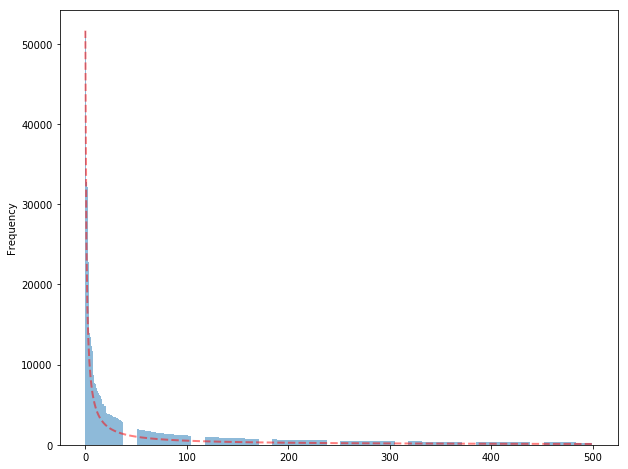

In [43]:
y_pos = np.arange(500)
plt.figure(figsize=(10,8))
s = 1
expected_zipf = [new_term_freq_df.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
plt.bar(y_pos, new_term_freq_df.sort_values(by='total', ascending=False)['total'][:500], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--', linewidth=2, alpha=0.5)
plt.ylabel('Frequency')